In [159]:
import zipfile
import pandas as pd
import numpy as np
import os
import shutil
import glob as gb
from textwrap import wrap
import matplotlib.pyplot as plt
import matplotlib.image as mat_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import layers, callbacks
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
from keras.layers import *
import warnings
warnings.filterwarnings("ignore")
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [71]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Swapnali
[nltk_data]     singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Swapnali
[nltk_data]     singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Swapnali
[nltk_data]     singh\AppData\Roaming\nltk_data...


True

In [2]:
#unzipping the file
extract_dir = 'DL_flikr'
with zipfile.ZipFile('flickr30k-images.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['flickr30k-images', '__MACOSX']


In [42]:
dfcsv = 'flickr_annotations_30k.csv'
df = pd.read_csv(dfcsv)

In [43]:
output_folder_train = "Flikr/Flikr_train"
os.makedirs(output_folder_train, exist_ok=True)

In [44]:
#to store for training and validation both
nt_images = 2000
# Counter for storing images for training and validation both
st_images = 0

In [45]:
#dataframe to store train
df1 = pd.DataFrame(columns=["image", "caption"])

In [40]:
imagesf = 'DL_flikr/flickr30k-images'
all_images = os.listdir(imagesf)

In [46]:
for filename in all_images:
    # Check if the image details exists in the Excel file
    if filename in df['filename'].values:
        # Getting the corresponding row 
        row = df[df['filename'] == filename].iloc[0]
        # image caption
        caption = row["raw"]
        
        # to store in train and validation set
        if st_images < nt_images:
            output_folder = output_folder_train
            st_images += 1
            # Append filename and caption to the DataFrame train
            df1 = df1.append({"image": filename, "caption": caption}, ignore_index=True)
        else:
            break
        
        # Copy image to output folder
        shutil.copy(os.path.join(imagesf, filename), os.path.join(output_folder, filename))
        
print("Images stored successfully.")

Images stored successfully.


In [47]:
df1.head()

,image,caption
0,1000092795.jpg,"[""Two young guys with shaggy hair look at thei..."
1,10002456.jpg,"[""Several men in hard hats are operating a gia..."
2,1000268201.jpg,"[""A child in a pink dress is climbing up a set..."
3,1000344755.jpg,"[""Someone in a blue shirt and hat is standing ..."
4,1000366164.jpg,"[""Two men, one in a gray shirt, one in a black..."


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    2000 non-null   object
 1   caption  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [12]:
df1.isnull().sum()

image      0
caption    0
dtype: int64

In [13]:
#to read image in one format
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    
    img = img_to_array(img)
    img = img/255.
    
    return img

In [14]:
def display_train_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(5):
        n+=1
        plt.subplot(1 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        #image = readImage(f"Flikr/Flikr_train/{temp_df.image[i]}")
        image_path = f"Flikr/Flikr_train/{temp_df.image[i]}"
        print("Image Path:", image_path)
        image = readImage(image_path)
        
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

Image Path: Flikr/Flikr_train/155215598.jpg
Image Path: Flikr/Flikr_train/123314995.jpg
Image Path: Flikr/Flikr_train/102617084.jpg
Image Path: Flikr/Flikr_train/133661473.jpg
Image Path: Flikr/Flikr_train/14526359.jpg


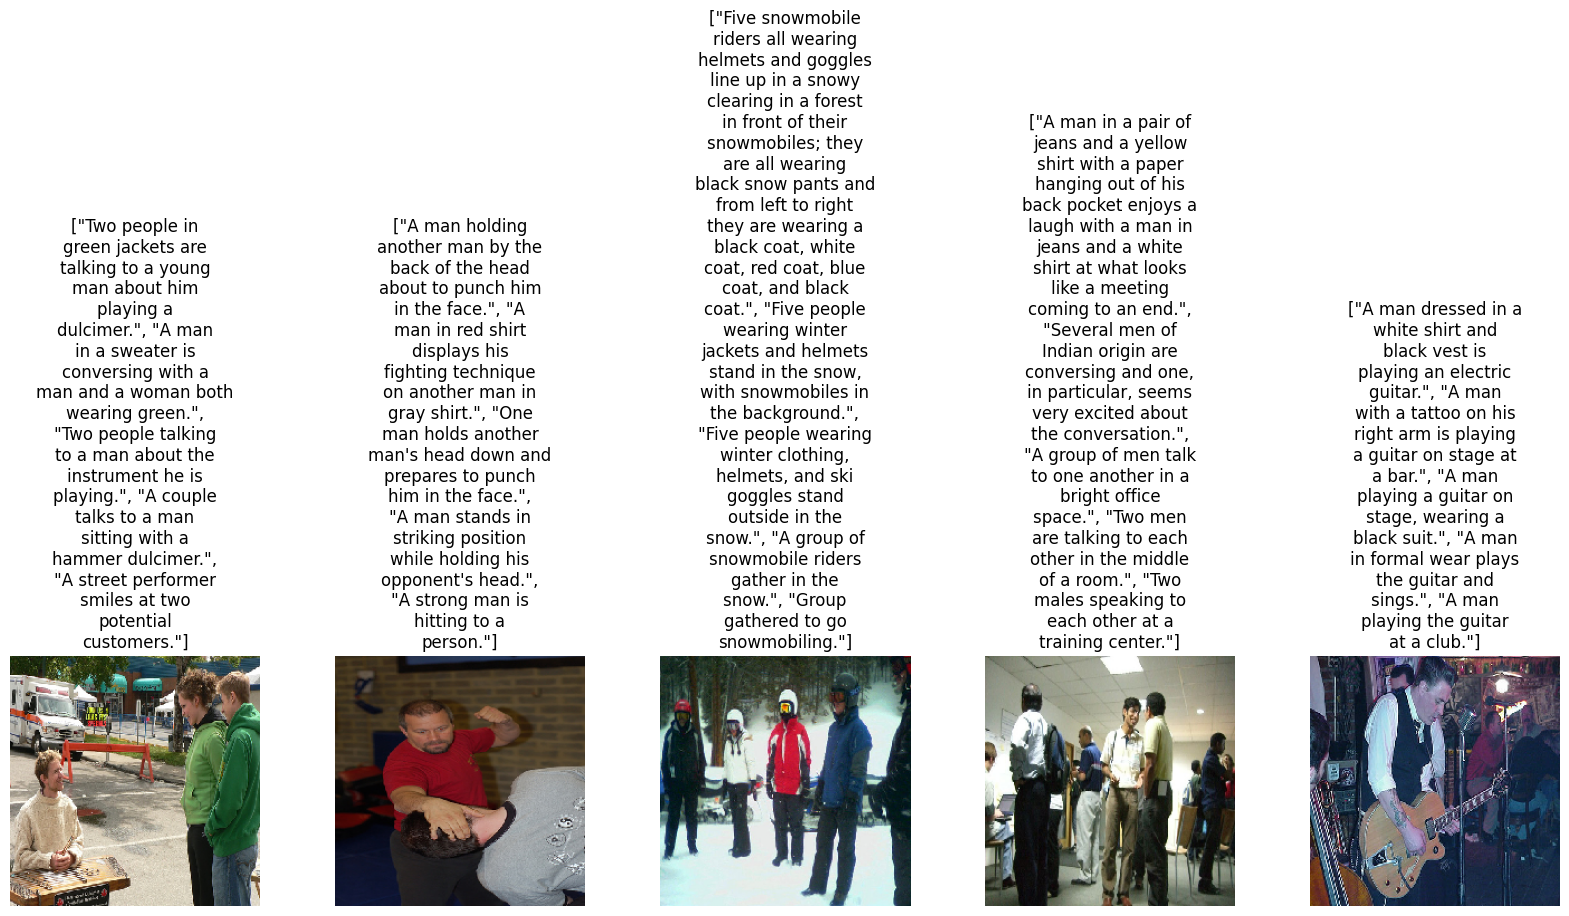

In [15]:
display_train_images(df1.sample(5))

In [54]:
import json
df1['caption'] = df1['caption'].apply(lambda x: json.loads(x))

# Create new columns with the split sentences
dft = df1['caption'].apply(lambda x: pd.Series(x))
dft.columns = [f"caption_{i+1}" for i in range(dft.shape[1])]

In [55]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   caption_1  2000 non-null   object
 1   caption_2  2000 non-null   object
 2   caption_3  2000 non-null   object
 3   caption_4  2000 non-null   object
 4   caption_5  2000 non-null   object
dtypes: object(5)
memory usage: 78.2+ KB


In [58]:
dfn = pd.concat([dft['caption_1'], df1['image']], axis=1)
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   caption_1  2000 non-null   object
 1   image      2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [76]:
captions = dfn['caption_1'].tolist()
new_cap = [preprocess_text(caption) for caption in captions]
# Storing preprocessed captions in a new column 
dfn['proc_caption_1'] = new_cap
# printing
print(dfn.head())

                                           caption_1           image  \
0  Two young guys with shaggy hair look at their ...  1000092795.jpg   
1  Several men in hard hats are operating a giant...    10002456.jpg   
2  A child in a pink dress is climbing up a set o...  1000268201.jpg   
3  Someone in a blue shirt and hat is standing on...  1000344755.jpg   
4  Two men, one in a gray shirt, one in a black s...  1000366164.jpg   

                                      proc_caption_1  
0   two young guy shaggy hair look hand hanging yard  
1  several men hard hat operating giant pulley sy...  
2      child pink dress climbing set stair entry way  
3  someone blue shirt hat standing stair leaning ...  
4  two men one gray shirt one black shirt standin...  


In [91]:
def text_preprocessing(data):
    data['caption_1'] = data['caption_1'].apply(lambda x: x.lower())
    data['caption_1'] = data['caption_1'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption_1'] = data['caption_1'].apply(lambda x: x.replace("\s+"," "))
    data['caption_1'] = data['caption_1'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption_1'] = "startseq "+data['caption_1']+" endseq"
    return data

In [94]:
dft1 = text_preprocessing(dft)
captions = dft1['caption_1'].tolist()
captions[:10]

['startseq startseq startseq two young guys with shaggy hair look at their hands while hanging out in the yard. endseq endseq endseq',
 'startseq startseq startseq several men in hard hats are operating giant pulley system. endseq endseq endseq',
 'startseq startseq startseq child in pink dress is climbing up set of stairs in an entry way. endseq endseq endseq',
 'startseq startseq startseq someone in blue shirt and hat is standing on stair and leaning against window. endseq endseq endseq',
 'startseq startseq startseq two men, one in gray shirt, one in black shirt, standing near stove. endseq endseq endseq',
 'startseq startseq startseq two people in the photo are playing the guitar and the other is poking at him. endseq endseq endseq',
 'startseq startseq startseq man sits in chair while holding large stuffed animal of lion. endseq endseq endseq',
 'startseq startseq startseq girl is on rollerskates talking on her cellphone standing in parking lot. endseq endseq endseq',
 'startseq s

In [95]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

In [ ]:
tokenizer.fit_on_texts(captions2)
vocab_size2 = len(tokenizer.word_index) + 1
max_length2 = max(len(caption.split()) for caption in captions2)

In [97]:
images = dfn['image'].unique().tolist()
nimages = len(images)

In [99]:
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = dfn[dfn['image'].isin(train_images)]
test = dfn[dfn['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 1, 1, 105, 37, 3, 257, 217, 14, 878, 615, 1139, 1140, 2, 2, 2]

In [129]:
dfn['caption']=dfn['caption_1']
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   caption_1       2000 non-null   object
 1   image           2000 non-null   object
 2   proc_caption_1  2000 non-null   object
 3   caption         2000 non-null   object
dtypes: object(4)
memory usage: 62.6+ KB


In [106]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
image_path = 'Flikr/Flikr_train'
img_size = 224
features = {}
for image in tqdm(dfn['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [18:13<00:00,  1.83it/s]


In [136]:
class DataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [137]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input1,input2], outputs=output)
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [149]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1920)]       0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 256)          491776      ['input_12[0][0]']               
                                                                                                  
 input_13 (InputLayer)          [(None, 52)]         0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 1, 256)       0           ['dense_6[0][0]']                
                                                                                            

In [150]:
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [167]:
dfntrain = dfn.iloc[:split_index]  # Training set (80%)
dfntest = dfn.iloc[split_index:]    # Testing set (20%)

# Print the training and testing DataFrames
print("Training Set:")
print(dfntrain)

print("\nTesting Set:")
print(dfntest)

Training Set:
                                              caption_1           image  \
0     Two young guys with shaggy hair look at their ...  1000092795.jpg   
1     Several men in hard hats are operating a giant...    10002456.jpg   
2     A child in a pink dress is climbing up a set o...  1000268201.jpg   
3     Someone in a blue shirt and hat is standing on...  1000344755.jpg   
4     Two men, one in a gray shirt, one in a black s...  1000366164.jpg   
...                                                 ...             ...   
1695  A little girl in pajamas runs down a hall with...  1481062342.jpg   
1696     Three young girls are standing on a riverbank.    14813436.jpg   
1697  A man and two women are seated outside on a wa...  1481393167.jpg   
1698  A young many wearing a red and blue uniform wh...  1481728325.jpg   
1699  A man in a yellow shirt is digging in a cave, ...  1482376928.jpg   

                                         proc_caption_1  \
0      two young guy shagg

In [169]:

image_path = 'Flikr/Flikr_train'
train_generator = DataGenerator(df=dfntrain,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)
image_path = 'Flikr/Flikr_train'
validation_generator = DataGenerator(df=dfntest,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [170]:
model_name = "cnnlstm_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [171]:
history = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 2.1417
Epoch 1: val_loss improved from inf to 1.47644, saving model to cnnlstm_model.h5
26/26 [==============================] - 111s 4s/step - loss: 2.1417 - val_loss: 1.4764 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 2.1157
Epoch 2: val_loss did not improve from 1.47644
26/26 [==============================] - 107s 4s/step - loss: 2.1157 - val_loss: 1.5411 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 2.0720
Epoch 3: val_loss did not improve from 1.47644
26/26 [==============================] - 107s 4s/step - loss: 2.0720 - val_loss: 1.6133 - lr: 0.0010
Epoch 4/30
26/26 [==============================] - ETA: 0s - loss: 2.0618
Epoch 4: val_loss did not improve from 1.47644

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
26/26 [==============================] - 110s 4s/step - loss: 2.0618 - val_loss: 1.6617 - lr: 0.0

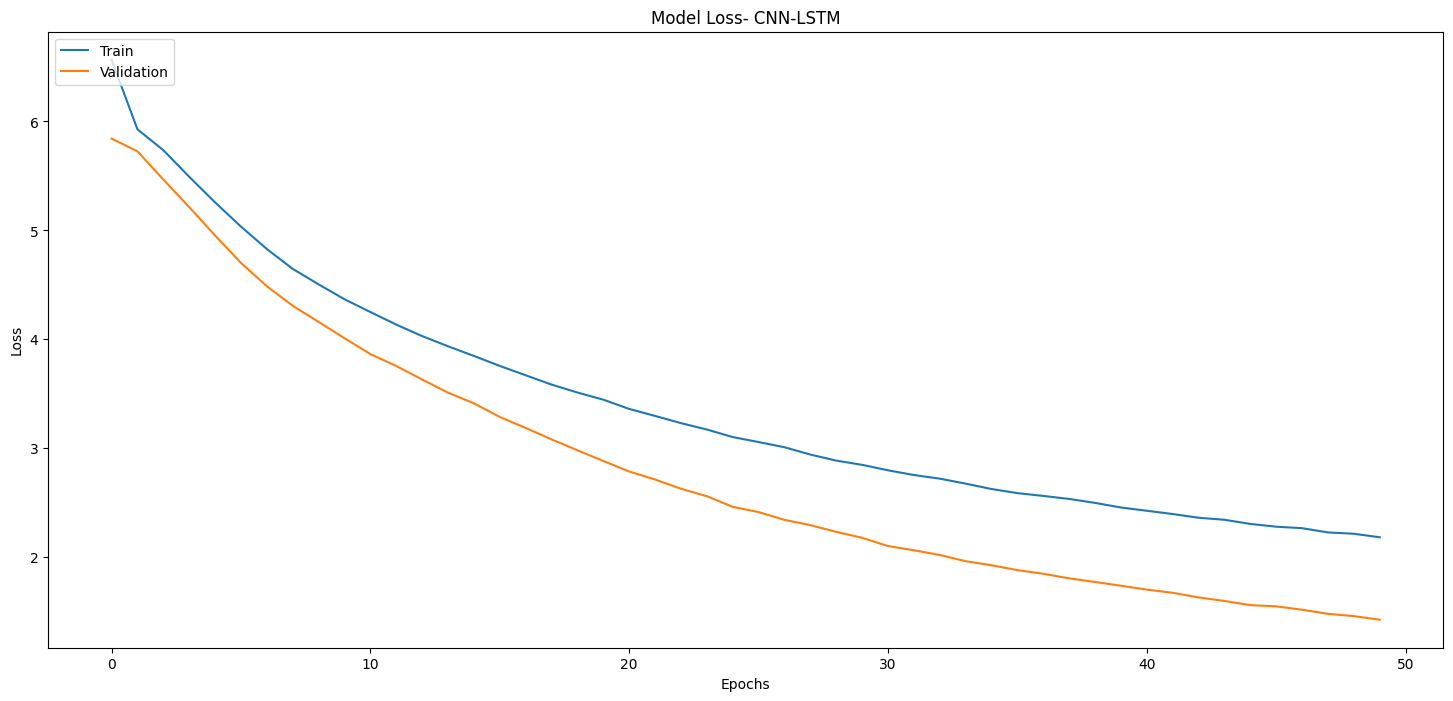

In [147]:
plt.figure(figsize=(18,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss- CNN-LSTM')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [152]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [153]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [154]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [155]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 31ms/step


Image Path: Flikr/Flikr_train/156222796.jpg
Image Path: Flikr/Flikr_train/150725531.jpg
Image Path: Flikr/Flikr_train/1522787272.jpg
Image Path: Flikr/Flikr_train/1534920819.jpg
Image Path: Flikr/Flikr_train/1547575241.jpg


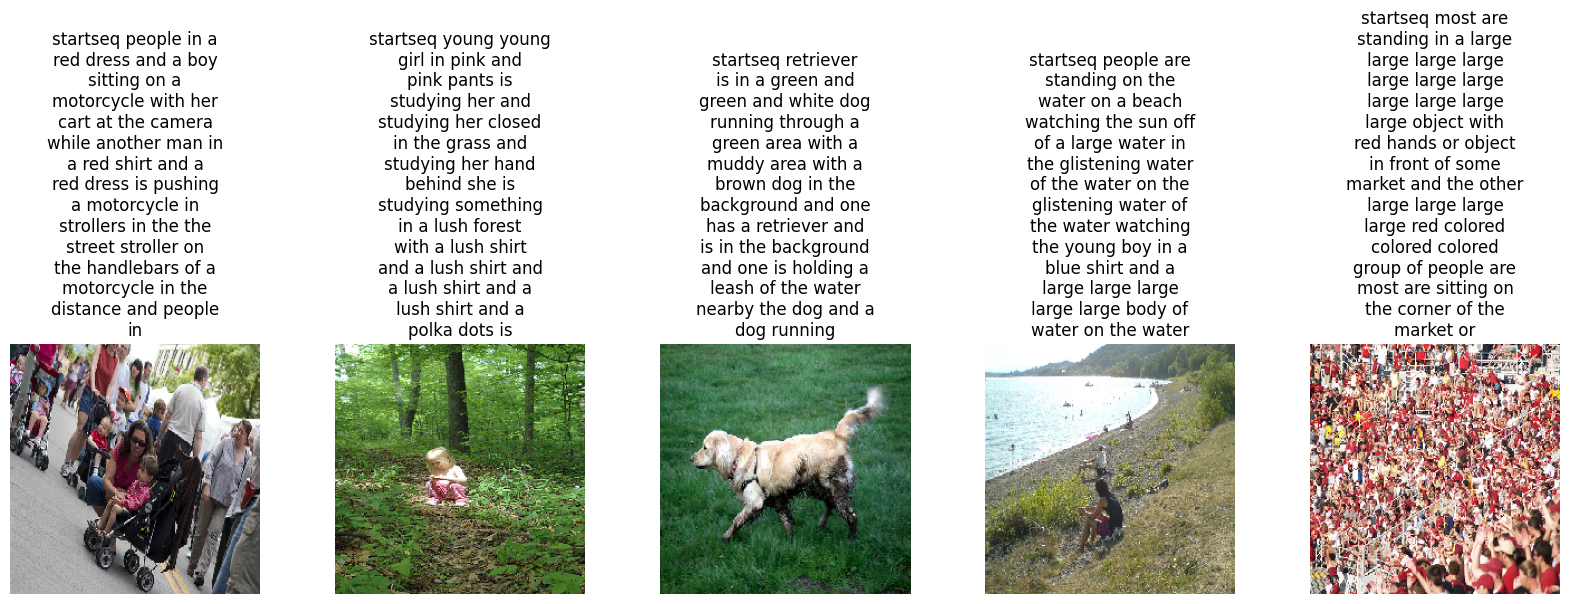

In [157]:
display_train_images(samples)

Image Path: Flikr/Flikr_train/156222796.jpg
Image Path: Flikr/Flikr_train/150725531.jpg
Image Path: Flikr/Flikr_train/1522787272.jpg
Image Path: Flikr/Flikr_train/1534920819.jpg
Image Path: Flikr/Flikr_train/1547575241.jpg


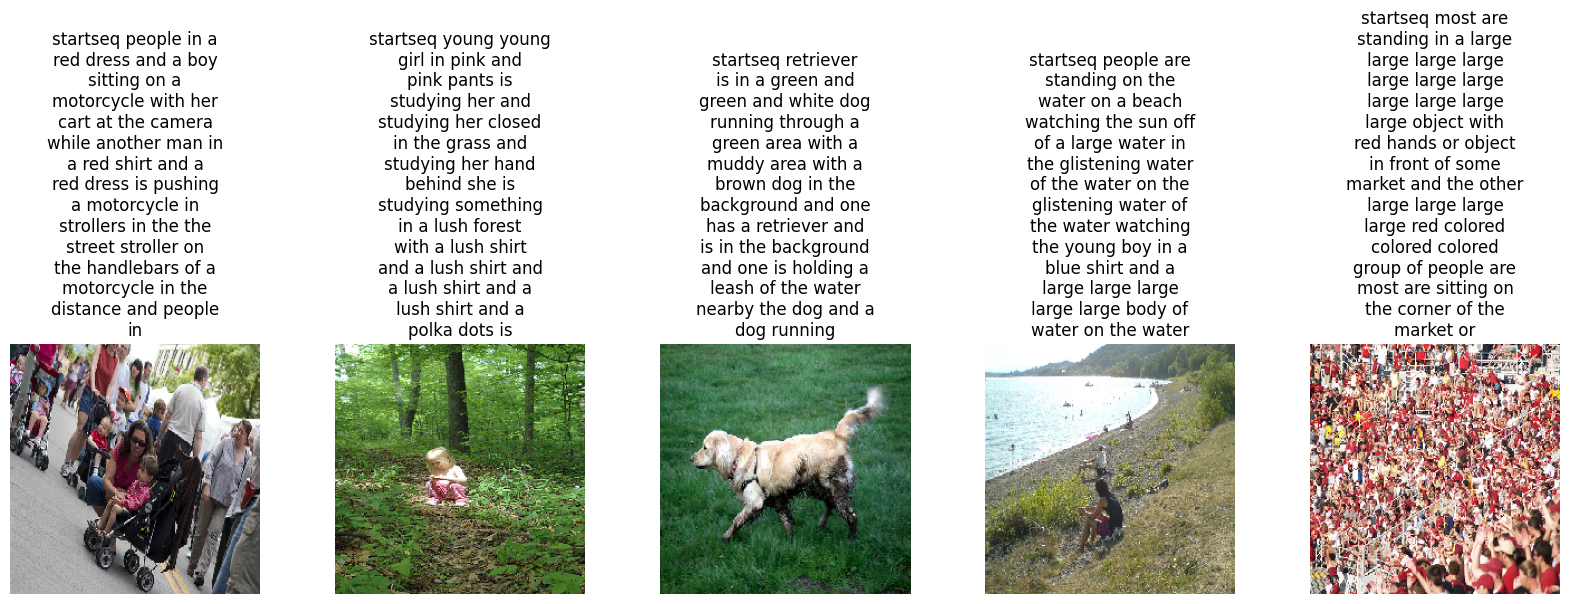

In [160]:
display_train_images(samples)